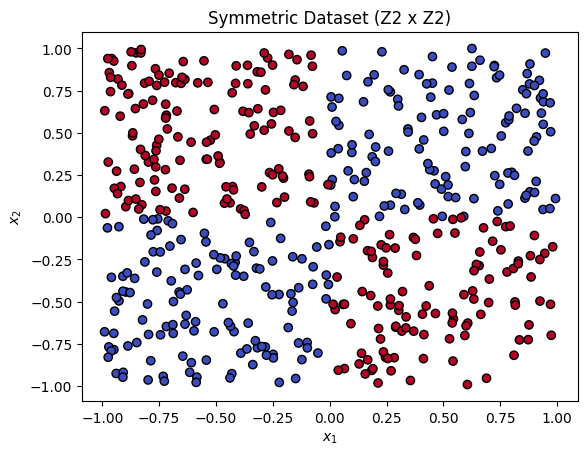

Training standard QNN...
Epoch 0: Loss = 1.1511
Epoch 10: Loss = 1.0894
Epoch 20: Loss = 0.9381
Epoch 30: Loss = 0.6335
Epoch 40: Loss = 0.4775
Epoch 50: Loss = 0.4216
Epoch 60: Loss = 0.3986
Epoch 70: Loss = 0.3887
Epoch 80: Loss = 0.3843
Epoch 90: Loss = 0.3823

Training equivariant QNN...
Epoch 0: Loss = 0.8076
Epoch 10: Loss = 0.4812
Epoch 20: Loss = 0.4096
Epoch 30: Loss = 0.3899
Epoch 40: Loss = 0.3843
Epoch 50: Loss = 0.3826
Epoch 60: Loss = 0.3822
Epoch 70: Loss = 0.3820
Epoch 80: Loss = 0.3820
Epoch 90: Loss = 0.3820

Test accuracy:
  Standard QNN: 94.67%
  Equivariant QNN: 94.00%


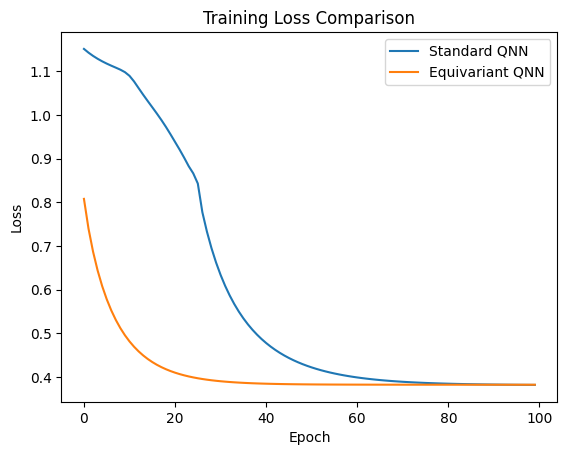

In [10]:
import pennylane as qml
from pennylane import numpy as np
import numpy as np_std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ======================================
# 1. Generate a Classification Dataset with Z2 x Z2 Symmetry
# ======================================
def generate_symmetric_dataset(N=500, seed=42):
    np_std.random.seed(seed)
    X = np_std.random.uniform(-1, 1, (N, 2))
    # Define labels: if x1 * x2 > 0 then label = 0 (same sign), else label = 1 (different sign)
    y = np.array([0 if x[0] * x[1] > 0 else 1 for x in X])
    return X, y

# Generate the dataset
X, y = generate_symmetric_dataset(500)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Plot the data distribution (to verify symmetry)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Symmetric Dataset (Z2 x Z2)")
plt.show()

# ======================================
# 2. Define Helper Functions: Convert QNode Output to Predicted Probability and Compute Cross-Entropy Loss
# ======================================
def predict_prob(expval):
    # We use: p = (1 + expval) / 2, mapping expval in [-1,1] to [0,1]
    return (1 + expval) / 2

def cross_entropy_loss(y_true, y_pred):
    # Binary cross-entropy loss
    return - (y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

# ======================================
# 3. Define Standard QNN (Non-Equivariant)
# ======================================
dev_std = qml.device("default.qubit", wires=2)

@qml.qnode(dev_std)
def qnn_standard(x, theta):
    # Feature encoding: use RY rotations to encode x[0] and x[1] into qubits 0 and 1
    qml.RY(np.pi * x[0], wires=0)
    qml.RY(np.pi * x[1], wires=1)
    
    # Variational layer (without enforcing symmetry)
    qml.RY(theta[0], wires=0)
    qml.RY(theta[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(theta[2], wires=0)
    qml.RY(theta[3], wires=1)
    return qml.expval(qml.PauliZ(0))

def loss_std(theta, X, y):
    loss = 0
    for xi, yi in zip(X, y):
        expval = qnn_standard(xi, theta)
        p = predict_prob(expval)
        loss += cross_entropy_loss(yi, p)
    return loss / len(X)

# ======================================
# 4. Define Z2 x Z2 Equivariant QNN
# ======================================
# The equivariant circuit uses parameter sharing, applying the same rotation to both qubits.
dev_eq = qml.device("default.qubit", wires=2)

@qml.qnode(dev_eq)
def qnn_equivariant(x, theta):
    # Feature encoding: directly encode the input into both qubits using RY rotations
    qml.RY(np.pi * x[0], wires=0)
    qml.RY(np.pi * x[1], wires=1)
    
    # Variational layer: apply the same parameter to both qubits (parameter sharing)
    qml.RY(theta[0], wires=0)
    qml.RY(theta[0], wires=1)  # Shared parameter
    qml.CNOT(wires=[0, 1])
    qml.RY(theta[1], wires=0)
    qml.RY(theta[1], wires=1)
    return qml.expval(qml.PauliZ(0))

def loss_eq(theta, X, y):
    loss = 0
    for xi, yi in zip(X, y):
        expval = qnn_equivariant(xi, theta)
        p = predict_prob(expval)
        loss += cross_entropy_loss(yi, p)
    return loss / len(X)

# ======================================
# 5. Training Process
# ======================================
# Initial parameters: Standard QNN has 4 parameters; Equivariant QNN has 2 parameters (due to parameter sharing)
np_std.random.seed(42)
theta_std = np.array(np_std.random.uniform(0, np.pi, 4), requires_grad=True)
theta_eq = np.array(np_std.random.uniform(0, np.pi, 2), requires_grad=True)

opt_std = qml.GradientDescentOptimizer(stepsize=0.1)
opt_eq = qml.GradientDescentOptimizer(stepsize=0.1)

num_epochs = 100

loss_history_std = []
loss_history_eq = []

print("Training standard QNN...")
for epoch in range(num_epochs):
    theta_std, loss_val = opt_std.step_and_cost(lambda th: loss_std(th, X_train, y_train), theta_std)
    loss_history_std.append(loss_val)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss_val:.4f}")

print("\nTraining equivariant QNN...")
for epoch in range(num_epochs):
    theta_eq, loss_val = opt_eq.step_and_cost(lambda th: loss_eq(th, X_train, y_train), theta_eq)
    loss_history_eq.append(loss_val)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss_val:.4f}")

# ======================================
# 6. Testing and Comparison
# ======================================
def predict_std(x, theta):
    expval = qnn_standard(x, theta)
    p = predict_prob(expval)
    return 1 if p >= 0.5 else 0

def predict_eq(x, theta):
    expval = qnn_equivariant(x, theta)
    p = predict_prob(expval)
    return 1 if p >= 0.5 else 0

y_pred_std = [predict_std(x, theta_std) for x in X_test]
y_pred_eq = [predict_eq(x, theta_eq) for x in X_test]

acc_std = accuracy_score(y_test, y_pred_std)
acc_eq = accuracy_score(y_test, y_pred_eq)

print("\nTest accuracy:")
print(f"  Standard QNN: {acc_std * 100:.2f}%")
print(f"  Equivariant QNN: {acc_eq * 100:.2f}%")

# Plot and save the training loss curves
plt.plot(loss_history_std, label="Standard QNN")
plt.plot(loss_history_eq, label="Equivariant QNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Comparison")
plt.savefig("training_loss_comparison.png")  # Save as PNG in the current folder
plt.show()


### Why Does the Standard QNN Achieve Slightly Higher Test Accuracy (94.67%) Compared to the Equivariant QNN (94.00%)?

There are several possible reasons for the observed performance difference between the standard QNN and the \(Z_2 \times Z_2\) equivariant QNN:

1. **Symmetry and Data Matching:**
   - Although the dataset respects the \(Z_2 \times Z_2\) symmetry, if the symmetry is not strongly expressed in all regions of the data or does not fully determine the classification, enforcing equivariance (i.e., parameter sharing) may constrain the model too much. This can lead to a reduced number of trainable parameters and, in some cases, a slightly lower performance compared to the standard QNN.

2. **Parameter Space and Expressivity:**
   - **Standard QNN:** Each qubit in the standard QNN has its own independent parameters. Thus, with the same circuit depth or number of layers, the standard QNN may have more adjustable parameters and, consequently, a higher expressive capacity.
   - **Equivariant QNN:** In contrast, the equivariant QNN uses parameter sharing to enforce symmetry (e.g., the same rotation is applied to multiple qubits). This reduces the model’s degrees of freedom, which might limit its ability to fully capture the data complexity if the symmetry does not dominate the data structure.

3. **Random Initialization and Optimization:**
   - The final performance may also be influenced by random initialization and the optimization trajectory. Even if both models eventually converge to similar loss values, slight differences due to random factors can result in a small difference in test accuracy.

4. **Model Depth or Structural Complexity:**
   - In some cases, if the equivariant QNN is not deep enough (or lacks sufficient entangling layers), it may not capture the complex patterns in the data as effectively as the standard QNN. Increasing the circuit depth or adding more entangling operations could potentially leverage the symmetry more fully.

5. **Data Size and Strength of the Symmetry Signal:**
   - If the dataset only weakly exhibits the \(Z_2 \times Z_2\) symmetry (i.e., the symmetry is not strongly pronounced in the features), the advantage of enforcing equivariance may not be significant. Additionally, with large amounts of data, the standard QNN might learn to approximate the symmetry implicitly, reducing the benefit of a hard-coded equivariant structure.

**Summary:**  
While an equivariant QNN is designed to leverage symmetry by reducing the number of parameters (via parameter sharing) and ideally achieve good generalization with fewer parameters, in practice, if the data’s symmetry is not very strong or if the model’s expressivity is limited by the imposed constraints, the standard QNN may perform slightly better. The observed slight difference in accuracy (94.67% vs. 94.00%) could be due to these factors, as well as differences in random initialization and optimization paths. Adjusting model depth, increasing the strength of the symmetry in the design, or tuning the optimization process might help the equivariant QNN achieve even better performance.
